# Caption Analysis

## Load Captions

In [1]:
import os
import json
import pandas as pd

In [2]:
path = '/data/bxc5446/pdffigures2/target/scala-2.11/results'

os.chdir(path)

# All caption filenames
captions = []

with os.scandir(path) as files:
    # Loop through file in directory
    for file in files:
        # We have png and json files, add only file with json ending
        if file.name.endswith('.json'):
            captions.append(file.name)

In [3]:
print(f'Number of Caption Files (each file contains 2-3 captions): {len(captions)}')

Number of Caption Files (each file contains 2-3 captions): 57504


The number of figures and tables we have is 98743, this means that some of the figures don't have captions

In [4]:
from PIL import Image

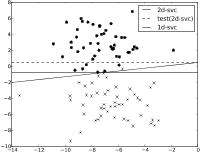

In [5]:
Image.open('C12-2114-Figure1-1.png')

In [6]:
# Inspect one json file
with open(captions[50]) as file:
    print(json.load(file)[3])

{'caption': 'Figure 1: Optimal decision boundary is not optimal when one dimension is removed', 'captionBoundary': {'x1': 75.82592010498047, 'x2': 357.3016662597656, 'y1': 212.9239959716797, 'y2': 217.510986328125}, 'figType': 'Figure', 'imageText': ['2d-svc', 'test(2d-svc)', '1d-svc', '8', '6', '4', '2', '0', '−2', '−4', '−6', '−8', '−14', '−12', '−10', '−8', '−6', '−4', '−2', '0', '−10'], 'name': '1', 'page': 2, 'regionBoundary': {'x1': 143.28, 'x2': 287.28, 'y1': 82.08, 'y2': 191.51999999999998}, 'renderDpi': 100, 'renderURL': 'results/C12-2114-Figure1-1.png'}


There are many fields in the json file, for our project we will only need the captions. 

In [7]:
# Extract the caption itself ['caption'] and the figure ['renderURL'] that it matches to from the json data. 
data = {}

for caption in captions:
    
    with open(caption) as file:
        for cap in json.load(file):
            try:
                data[cap['renderURL']] = cap['caption']
            except:
                data[cap['renderURL']] = 'empty'

In [8]:
# Tranform to dataframe for easier processing
cap_data = pd.DataFrame(list(data.items()), columns=['file', 'caption'])

cap_data

,file,caption
0,results/1987.mtsummit-1.14-Figure3-2-1.png,Figure 3-2 SENTENCE STRUCTURE
1,results/1987.mtsummit-1.14-Figure3-3-1.png,Figure 3-3 shows the flow of the syntactic and...
2,results/1987.mtsummit-1.14-Figure3-7-1.png,Figure 3-7 GENERATION OF MORPHOLOGICAL INFORMA...
3,results/1987.mtsummit-1.14-Figure3-6-1.png,Figure 3-6 TYPICAL TRANSFER PROBLEM CAUSED BY ...
4,results/1987.mtsummit-1.14-Figure3-1-1.png,Figure 3-1 WORD STRUCTURE
...,...,...
298843,results/P19-3033-Figure2-1.png,Figure 2: Outline of the process used to ident...
298844,results/P19-3034-Figure2-1.png,Figure 2: An example of auto-generated test it...
298845,results/P19-3034-Table2-1.png,Table 2: WSD evaluation
298846,results/P19-3034-Figure1-1.png,Figure 1: An example Linggle Booster session f...


## Data Preprocessing

From initial inspection of the data, some first step would be remove the files with no captions. Additionally, since we are not working with tables in this project, we need to remove captions which are intended for tables.

In [9]:
df = cap_data[cap_data['caption'] != 'empty']

print(f'We removed {cap_data.shape[0] - df.shape[0]} empty caption files')

We removed 0 empty caption files


In [10]:
# seperate file that starts with t or T, indicating it is for tables
index = df['caption'].str.contains(r'^[Tt]')

tables = df[index]
df = df[~index]

print(f'We removed {tables.shape[0]} files which are tables, now we have {df.shape[0]} files of figure captions')

We removed 175129 files which are tables, now we have 123719 files of figure captions


In [11]:
df.head()

,file,caption
0,results/1987.mtsummit-1.14-Figure3-2-1.png,Figure 3-2 SENTENCE STRUCTURE
1,results/1987.mtsummit-1.14-Figure3-3-1.png,Figure 3-3 shows the flow of the syntactic and...
2,results/1987.mtsummit-1.14-Figure3-7-1.png,Figure 3-7 GENERATION OF MORPHOLOGICAL INFORMA...
3,results/1987.mtsummit-1.14-Figure3-6-1.png,Figure 3-6 TYPICAL TRANSFER PROBLEM CAUSED BY ...
4,results/1987.mtsummit-1.14-Figure3-1-1.png,Figure 3-1 WORD STRUCTURE


Before doing exploratory analysis on our data, we will perform standard text cleaning and processing procedures on our captions.

In [12]:
import re
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [13]:
def clean_text(text):
    # Lower case
    text = text.lower()
    
    # Strip extra whitespace
    text = text.strip()
    
    # Since we know all captions are figures, we can remove the indication
    text = re.sub(r'^fig[a-z]*.\s[0-9].', '', text)
    text = text.strip()
    
    return text

In [14]:
df['clean text'] = df.apply(lambda row: clean_text(row['caption']), axis=1)

After having our text cleaned, we can do some plots to explore the shape of our captions.

In [15]:
import nltk 
from nltk.tokenize import sent_tokenize

df['num_words'] = df.apply(lambda row: len(row['caption'].split()), axis=1)
df['num_sentence'] = df.apply(lambda row: len(sent_tokenize(row['caption'])), axis=1)

(0.0, 100.0)

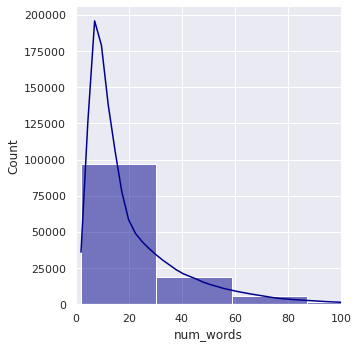

In [16]:
sns.displot(df['num_words'], kde=True, bins=int(180/10), color='darkblue')
plt.xlim(0, 100)


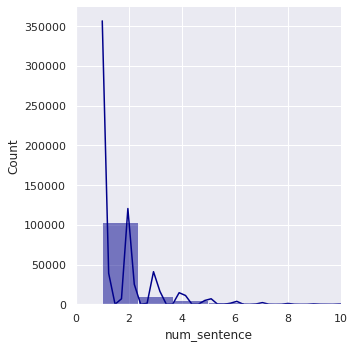

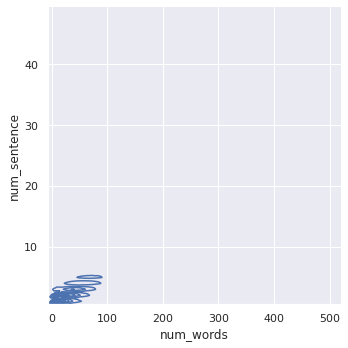

In [17]:
ns_plot = sns.displot(df['num_sentence'], kde=True, bins=int(180/5), color='darkblue')
plt.xlim(0, 10)
sns.displot(data=df, x='num_words', y='num_sentence', kind='kde')

From the plots, we can see that most of our caption has less than 100 words and less than 10 sentences.

In [60]:
df[df.num_sentence == 2].iloc[12]['caption']

'Figure 1: A motivating example for fact checking and the FEVER task. Verifying the claim requires understanding the semantic structure of multiple evidence sentences and the reasoning process over the structure.'

***

Preprocess all the captions
* Give special token to the numbers
* Get rid of caption that are too long or too short
* Select the first couple of sentenced for caption with more than 2 sentences

***

Now we can process the data by removing outliers in terms of number of words. Since our data is not normally distributed, we will use IQR to remove the outlier. 

In [66]:
import numpy as np

<AxesSubplot:xlabel='num_words'>

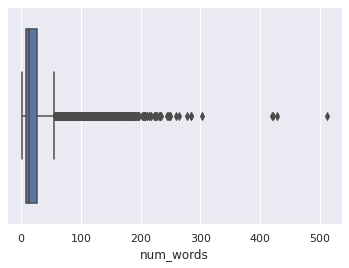

In [76]:
# Plot box plot
sns.boxplot(x=df['num_words'])

<AxesSubplot:xlabel='num_sentence'>

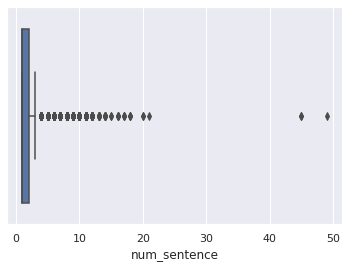

In [ ]:
sns.boxplot(x=df['num_sentence'])

In [83]:
p25 = df['num_words'].quantile(0.25)
p75 = df['num_words'].quantile(0.75)

# Calculate IQR
q3, q1 = np.percentile(df['num_words'], [75, 25])
iqr = q3 - q1


upper = p75 + 1.5*iqr
lower = p25 - 1.5*iqr

print(f'The upper limit cutoff is {upper} and the lower limit cutoff is {lower}')

The upper limit cutoff is 55.5 and the lower limit cutoff is -20.5


In [96]:
new_df = df[df['num_words'] < upper]

print(f'We removed {df.shape[0] - new_df.shape[0]} outliers')

We removed 8775 outliers


<AxesSubplot:xlabel='num_words'>

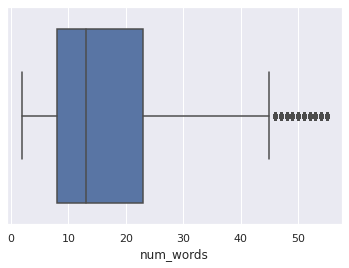

In [99]:
sns.boxplot(x=new_df['num_words'])

In [193]:
l25 = df['num_sentence'].quantile(0.25)
l75 = df['num_sentence'].quantile(0.75)
l3, l1 = np.percentile(df['num_sentence'], [75,25])
liqr = l3-l1
lupper = l75 + 1.5*liqr
llower = l25 - 1.5*liqr
new2_df = df[df['num_sentence'] < upper]

In [194]:
# Examine long sentences 
df[df['num_sentence'] > 4][0:4]

,file,caption,clean text,num_words,num_sentence
56,results/E17-1114-Figure1-1.png,"Figure 1: Multitask method. Words are represented in the Word2Vec space. Such representations are averaged per window. Sequences are feed to GRU network. Finally, the features are feed to two softmax components to predict genre and success simultaneously.","multitask method. words are represented in the word2vec space. such representations are averaged per window. sequences are feed to gru network. finally, the features are feed to two softmax components to predict genre and success simultaneously.",38,5
96,results/C12-2115-Figure3-1.png,"Figure 3: Results, incl. language-level weighting (gtree and typology), unsupervised model selection (pr), instance-weighted extensions (w–) and a comparison with recent work. AV is macro-average, and AVM is macro-average on the 8 languages used in McDonald et al. (2011). The voted systems (a) and (b) take non-weighted votes over the systems in the above rows.","results, incl. language-level weighting (gtree and typology), unsupervised model selection (pr), instance-weighted extensions (w–) and a comparison with recent work. av is macro-average, and avm is macro-average on the 8 languages used in mcdonald et al. (2011). the voted systems (a) and (b) take non-weighted votes over the systems in the above rows.",55,5
134,results/N09-1068-Figure1-1.png,"Figure 1: (a) No domain adaptation. The model parameters, θ , are normally distributed, with mean µ (typically zero) and variance σ2. The likelihood of the data, D , is dependent on the model parameters. The form of the data distribution depends on the underlying model (e.g., logistic regression, or a CRF). (b) Our hierarchical domain adaptation model. The top-level parameters, θ∗, are normally distributed, with mean µ (typically zero) and variance σ2∗ . There is a plate for each domain. Within each plate, the domain-specific parameters, θd are normally distributed, with mean θ∗ and variance σ2d . (c) Our hierarchical domain adaptation model, with an extra level of structure. In this example, the domains are further split into text and speech super-domains, each of which has its own set of parameters (θtxt and σtxt for text and θsp and σsp for speech). θd is normally distributed with mean θtxt if domain d is in the text super-domain, and θsp if it is in the speech super-domain.","(a) no domain adaptation. the model parameters, θ , are normally distributed, with mean µ (typically zero) and variance σ2. the likelihood of the data, d , is dependent on the model parameters. the form of the data distribution depends on the underlying model (e.g., logistic regression, or a crf). (b) our hierarchical domain adaptation model. the top-level parameters, θ∗, are normally distributed, with mean µ (typically zero) and variance σ2∗ . there is a plate for each domain. within each plate, the domain-specific parameters, θd are normally distributed, with mean θ∗ and variance σ2d . (c) our hierarchical domain adaptation model, with an extra level of structure. in this example, the domains are further split into text and speech super-domains, each of which has its own set of parameters (θtxt and σtxt for text and θsp and σsp for speech). θd is normally distributed with mean θtxt if domain d is in the text super-domain, and θsp if it is in the speech super-domain.",167,11
274,results/L16-1361-Figure3-1.png,"Figure 3: Results of comparing the list from Figure 2 with a list of terms obtained from a set of text about 1M tokens concerning music (mainly jazz). An additional column with the LL value is visible. Colors (gray-levels) show terms which occur in both corpora. The darker the color, the bigger the distributional difference. In the left window, comparison is made based on term frequencies; in the right window, C-values were used.","results of comparing the list from figure 2 with a list of terms obtained from a set of text about 1m tokens concerning music (mainly jazz). an additional

Some data suggest it is caption for figures with multiple subplots. Those usually contain (a), (b), etc. We can label those captions as captions for figures with subfigures. This will both help us avoid long captions but also identify which figures has subfigures. Afterwards, we can only extract the first 3 sentences for captions that has more than 3 sentences.

In [195]:
new2_df['subfigure'] = new2_df['clean text'].str.contains(r'\(a\).*\(b\)')

In [196]:
sf_count = new2_df[new2_df['subfigure'] == True].shape[0]
print(f'There are {sf_count} captions for subfigures')

There are 3955 captions for subfigures


In [197]:
# Extract first 3 sentence for long captions

def cut_sent(caption, num_sent):
    
    if num_sent > 3:
        new_cap = ' '.join([str(item) for item in sent_tokenize(caption)[0:3]])
        return new_cap
    else:
        return caption

In [198]:
new2_df['clean text'] = new2_df.apply(lambda row: cut_sent(row['clean text'], row['num_sentence']), axis=1)

In [199]:
# Generate new counts for the captions
new2_df['num_sentence'] = new2_df.apply(lambda row: len(sent_tokenize(row['clean text'])), axis=1)

In [204]:
new2_df['num_sentence'].describe()

count    123719.000000
mean          1.443699
std           0.730123
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           4.000000
Name: num_sentence, dtype: float64

In [207]:
# Export the cleaned caption dataframe
new2_df.to_csv('captions.csv')